# Outlier Analysis
### Gavin Rolls

This notebook details the work done to a) identify outliers from the POI-only models run in the Modelling notebook and b) Understand how those locations might differ from other LSOAs

### Library Imports

In [49]:
#Basics
import pandas as pd
import geopandas as gpd
import numpy as np

#Plots and Stats
import matplotlib.pyplot as plt
import seaborn as sns

# Geometry
from shapely import wkt
from shapely.wkt import loads
from shapely.geometry import Polygon, MultiPolygon

### Data Loading

In [9]:
# London & Birmingham All Data

all_data_london = pd.read_csv("data/combined_data/lag/all_data_london_lag.csv")
all_data_bham = pd.read_csv("data/combined_data/lag/all_data_bham_lag.csv")

In [33]:
# LSOA Atlas Features

lsoa_atlas = pd.read_csv("data/lsoa_data/lsoa_atlas.csv", header = None)

#Condense Header into One
header_row1 = lsoa_atlas.iloc[0].astype(str)
header_row2 = lsoa_atlas.iloc[1].astype(str)

new_header = header_row1 + ' ' + header_row2
lsoa_atlas.columns = new_header
lsoa_atlas = lsoa_atlas[2:]

lsoa_atlas.rename(columns={'nan Codes': 'LSOA11CD', 'nan Names': 'LSOA11NM'}, inplace=True)

census_year_columns = [col for col in lsoa_atlas.columns if col.endswith('2011')]

# Create a new DataFrame with only the last year columns
lsoa_atlas_last_year = lsoa_atlas[['LSOA11CD', 'LSOA11NM'] + census_year_columns]

# Reset index
lsoa_atlas.reset_index(drop=True, inplace=True)

lsoa_atlas.head()

/var/folders/2b/877nyyk109x4dd8hgx4ckwl40000gn/T/ipykernel_58478/3653397726.py:3: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,174,175,176,178,179,180,181,182,183,184) have mixed types. Specify dtype option on import or set low_memory=False.
  lsoa_atlas = pd.read_csv("data/lsoa_data/lsoa_atlas.csv", header = None)


,LSOA11CD,LSOA11NM,All Ages 2001,All Ages 2002,All Ages 2003,All Ages 2004,All Ages 2005,All Ages 2006,All Ages 2007,All Ages 2008,...,Median Price (£) 2011,Median Price (£) 2012,Median Price (£) 2013,Median Price (£) 2014,Sales 2009,Sales 2010,Sales 2011,Sales 2012,Sales 2013,Sales 2014
0,E01000907,Camden 001A,1519,1538,1528,1547,1593,1492,1455,1457,...,415000,355000,481250,568500,9,14,11,12,16,26
1,E01000908,Camden 001B,1547,1577,1605,1637,1629,1598,1605,1526,...,282500,335000,287500,350000,23,17,21,27,24,22
2,E01000909,Camden 001C,1600,1598,1618,1634,1610,1635,1615,1584,...,435000,1475000,1052000,1412500,11,15,19,15,16,16
3,E01000912,Camden 001D,1738,1728,1678,1707,1710,1669,1645,1618,...,500000,373000,572750,725000,17,22,17,10,10,11
4,E01000913,Camden 001E,1617,1676,1662,1714,1705,1690,1716,1657,...,1000000,737500,734500,996585,35,44,31,30,22,33


In [123]:
# POI Modelling Results (Models 19 + 20)

london_model = pd.read_csv("data/combined_data/model_results_london_poi.csv", index_col=0)
bham_model = pd.read_csv("data/combined_data/model_results_bham_poi.csv", index_col=0)

# Convert Geometry col to make GeoDataFrame
london_model['geometry'] = london_model['geometry'].apply(loads)
london_model = gpd.GeoDataFrame(london_model, crs='EPSG:4326', geometry = london_model['geometry'])

bham_model['geometry'] = bham_model['geometry'].apply(loads)
bham_model = gpd.GeoDataFrame(bham_model, crs='EPSG:4326', geometry = bham_model['geometry'])

london_model.head()

,geometry,observed,predicted
0,"POLYGON ((0.17380 51.56013, 0.17379 51.56012, ...",6.565265,5.057694
1,"POLYGON ((0.16598 51.55250, 0.16601 51.55248, ...",8.355850,7.893040
2,"POLYGON ((0.15965 51.54776, 0.15974 51.54771, ...",5.768321,6.039518
3,"POLYGON ((0.18508 51.56480, 0.18476 51.56454, ...",5.323010,5.086926
4,"POLYGON ((0.17599 51.56476, 0.17601 51.56475, ...",5.686975,5.234150


In [125]:
# Select Outliers - Z score over or under 3

# Create residual column (predicted - actual)
london_model['residual'] = london_model['observed'] - london_model['predicted']
bham_model['residual'] = bham_model['observed'] - bham_model['predicted']

bham_model.head()


,geometry,observed,predicted,residual
0,"POLYGON ((-1.80957 52.47014, -1.80953 52.47009...",6.120297,6.563520,-0.443222
1,"POLYGON ((-1.82792 52.46893, -1.82768 52.46891...",3.401197,3.956987,-0.555790
2,"POLYGON ((-1.82144 52.46633, -1.82143 52.46632...",7.501082,6.655694,0.845388
3,"POLYGON ((-1.82576 52.46527, -1.82579 52.46516...",7.859413,7.994729,-0.135315
4,"POLYGON ((-1.80450 52.46160, -1.80414 52.46135...",4.499810,4.552658,-0.052848


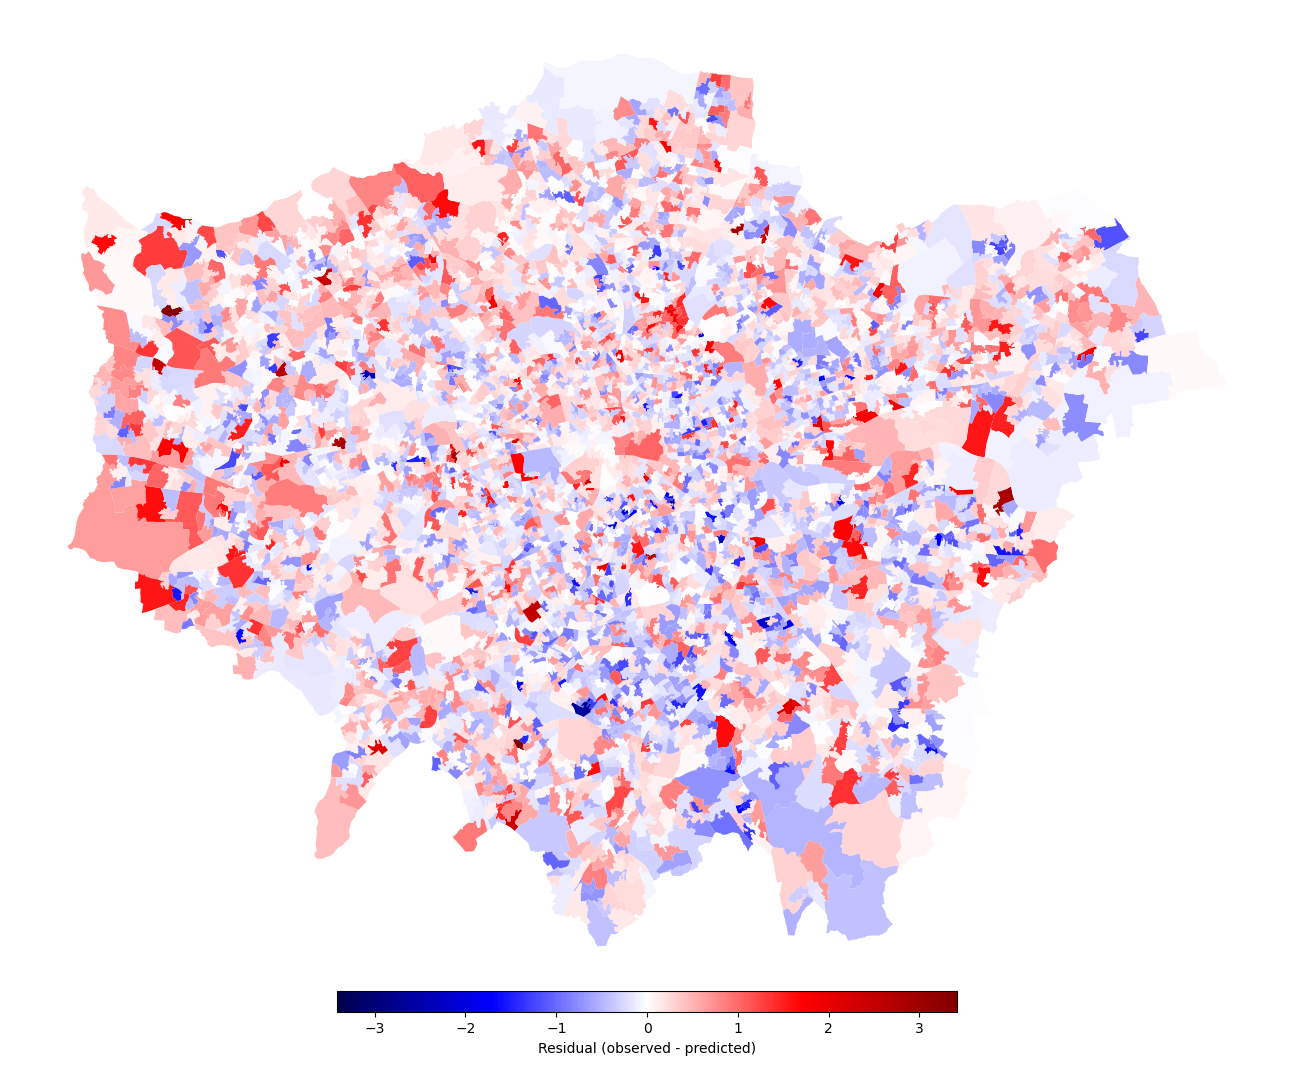

In [127]:
# Plot Residuals London (log)

vmax = max(abs(london_model['residual'].max()), abs(london_model['residual'].min()))

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
london_model.plot(ax=ax, column='residual', linewidth=0, legend = True, cmap='seismic',
                      vmin=-vmax, vmax=vmax,
                     legend_kwds = {
                         'label': "Residual (observed - predicted)",
                        'orientation': "horizontal",
                        'pad' : 0.00,
                        'shrink': 0.4,
                        'aspect': 30})

ax.set_axis_off()
plt.show()

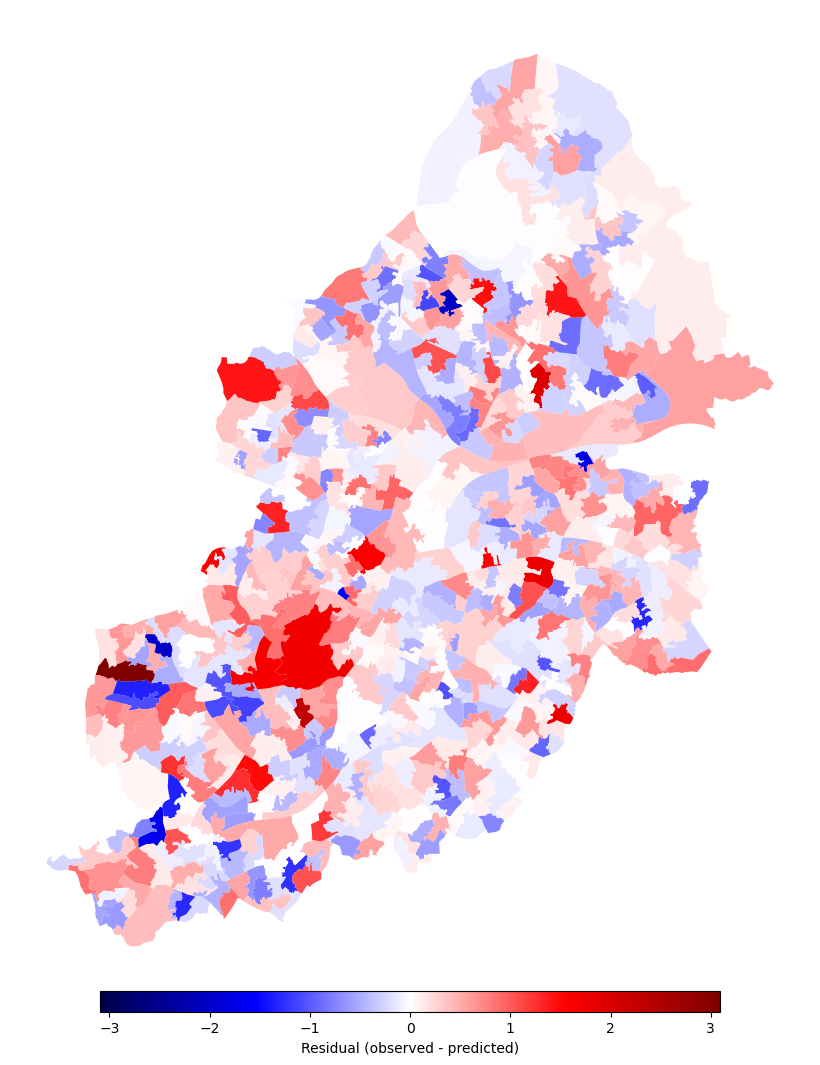

In [129]:
# Plot Residuals Birmingham (log)

vmax = max(abs(bham_model['residual'].max()), abs(bham_model['residual'].min()))

fig, ax = plt.subplots(1, 1, figsize=(20, 15))
bham_model.plot(ax=ax, column='residual', linewidth=0, legend = True, cmap='seismic',
                      vmin=-vmax, vmax=vmax,
                     legend_kwds = {
                         'label': "Residual (observed - predicted)",
                        'orientation': "horizontal",
                        'pad' : 0.00,
                        'shrink': 0.4,
                        'aspect': 30})

ax.set_axis_off()
plt.show()

In [37]:
# Spatial Analysis/Mapping of Outliers Only

# Make new outliers column - set areas that don't meet certain residual threshold to zero

# Map

In [ ]:
# Feature Analysis of Outliers

# Compare average of non-outlier set against outlier set 